### This script allows to load OLR data, detect cloud bands and then do the inheritance tracking

In [1]:
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from cloudbandpy.load_driver import run_load_data
from cloudbandpy.cb_detection import detection_workflow

from cloudbandpy.tracking import plot_tracking_on_map, tracking
from cloudbandpy.io_utilities import load_ymlfile, load_list, subset_latitudes, subset_longitudes
from cloudbandpy.time_utilities import create_list_of_dates, add_startend_datetime2config

Load configuration file and make adjustements for this test case

In [2]:
config_file = "../config/config_cbworkflow_southPacific.yml"
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Make sure that the period for the cloud bands cover the same period as the example data
config_event["startdate"] = "20210219.00"
config_event["enddate"] = "20210228.00"

config_event["clouddata_path"] = os.path.join("../data")
config_event["parameters_file"] = os.path.join("../parameters/parameters_southhemisphere.yml")

# No need to save any files
config_event["load_saved_files"] = False
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

# filepath = f"{config['saved_dirpath']}list_of_cloud_bands"+config['startdate']+"-"+config['enddate']+"-"+config['domain']+".bin"
# print("Example data exists:", os.path.isfile(filepath))
# print("file is:", filepath)
print(config)

2023-11-21 15:30:16,214 - io_utilities.load_ymlfile - INFO: Configuration file loaded


{'run_inheritance_tracking': True, 'startdate': '20160101.00', 'enddate': '20160130.00', 'domain': 'southPacific', 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50, 'clouddata_path': './ERA5/netcdf/3hourly/surface_level/', 'varname_infilename': 'top_net_thermal_radiation', 'qd_var': True, 'datatimeresolution': 3.0, 'period_detection': 24.0, 'olr_convert2wm2': True, 'varname': 'ttr', 'timecoord_name': 'time', 'xcoord_name': 'longitude', 'ycoord_name': 'latitude', 'select_djfm': False, 'parameters_file': './cloudbandPy/parameters/parameters_southhemisphere.yml', 'saved_dirpath': './cloud_band_files', 'save_dailyvar': False, 'save_listcloudbands': True, 'load_saved_files': False, 'dir_figures': './cloud_band_figures', 'fig_detection_process': False, 'fig_time_evolution_object': False, 'fig_time_evolution_var_cloudband': False, 'fig_overlay_cloudband': False, 'fig_show_bbox_around_blobs': False, 'fig_inheritance_tracking': False, 'fig_density': Fals

Load cloud bands from the South Pacific for the dates specified in the analyses config file

In [3]:
add_startend_datetime2config(config_event)
listofdates = create_list_of_dates(config_event)
print(str(len(listofdates))+" dates created from "+str(listofdates[0])+" to "+str(listofdates[-1]))

10 dates created from 2021-02-19 00:00:00 to 2021-02-28 00:00:00


Load data

In [4]:
olr2process, parameters, listofdates, lats, lons, resolution = run_load_data(config_event)

2023-11-21 15:30:16,286 - load_driver.run_load_data - INFO: Loading data and parameters 
2023-11-21 15:30:16,289 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2023-11-21 15:30:16,290 - io_utilities.load_dataset - INFO: Loading dataset from ../data
2023-11-21 15:30:16,291 - io_utilities.load_dataset - INFO: Loading 2021 --> 2021
2023-11-21 15:30:17,876 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2023-11-21 15:30:17,878 - io_utilities.make_daily_average - INFO: Computation of daily average
2023-11-21 15:30:18,155 - io_utilities.make_daily_average - INFO: Computation of daily average done
2023-11-21 15:30:18,157 - io_utilities.load_dataset - INFO: Dataset loaded


Run detection

In [5]:
(
        _,
        _,
        _,
        _,
        cloud_bands_over_time,
        list_of_cloud_bands,
    ) = detection_workflow(
        var2process=olr2process,
        parameters=parameters,
        latitudes=lats,
        longitudes=lons,
        resolution=resolution,
        listofdates=listofdates,
        config=config,
    )

2023-11-21 15:30:18,192 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-11-21 15:30:18,336 - cb_detection.detection_workflow - INFO: Cloud band detection done


Get life cycle of each cloud band

In [6]:
print(parameters["othresh"])

0.1


In [7]:
list_of_cloud_bands = tracking(list_of_cloud_bands, resolution, overlapfactor=parameters["othresh"])

2023-11-21 15:30:18,352 - cloudbandpy.tracking - INFO: Inheritance tracking in progress
2023-11-21 15:30:18,355 - cloudbandpy.tracking - INFO: Inheritance tracking done


Import longitudes and latitudes for the map

In [8]:
lons_globe = np.arange(0,360,.5)
lats_globe = np.arange(90,-90.5,-.5)
print(lats_globe.all()==lats_globe.all())
# Get longitudes and latitudes of South Pacific domain
_, lonsSP = subset_longitudes(lons_globe, config["lon_west"], config["lon_east"])
_, latsSP = subset_latitudes(lats_globe, config["lat_north"], config["lat_south"])

print(f"Longitudes, min: {lonsSP.min()}, max: {lonsSP.max()}")
print(f"Latitudes, min: {latsSP.min()}, max: {latsSP.max()}")

True
Longitudes, min: 130.0, max: 290.0
Latitudes, min: -50.0, max: 5.0


Create the series of map with connection lines between the centroid lcoation of each cloud bands

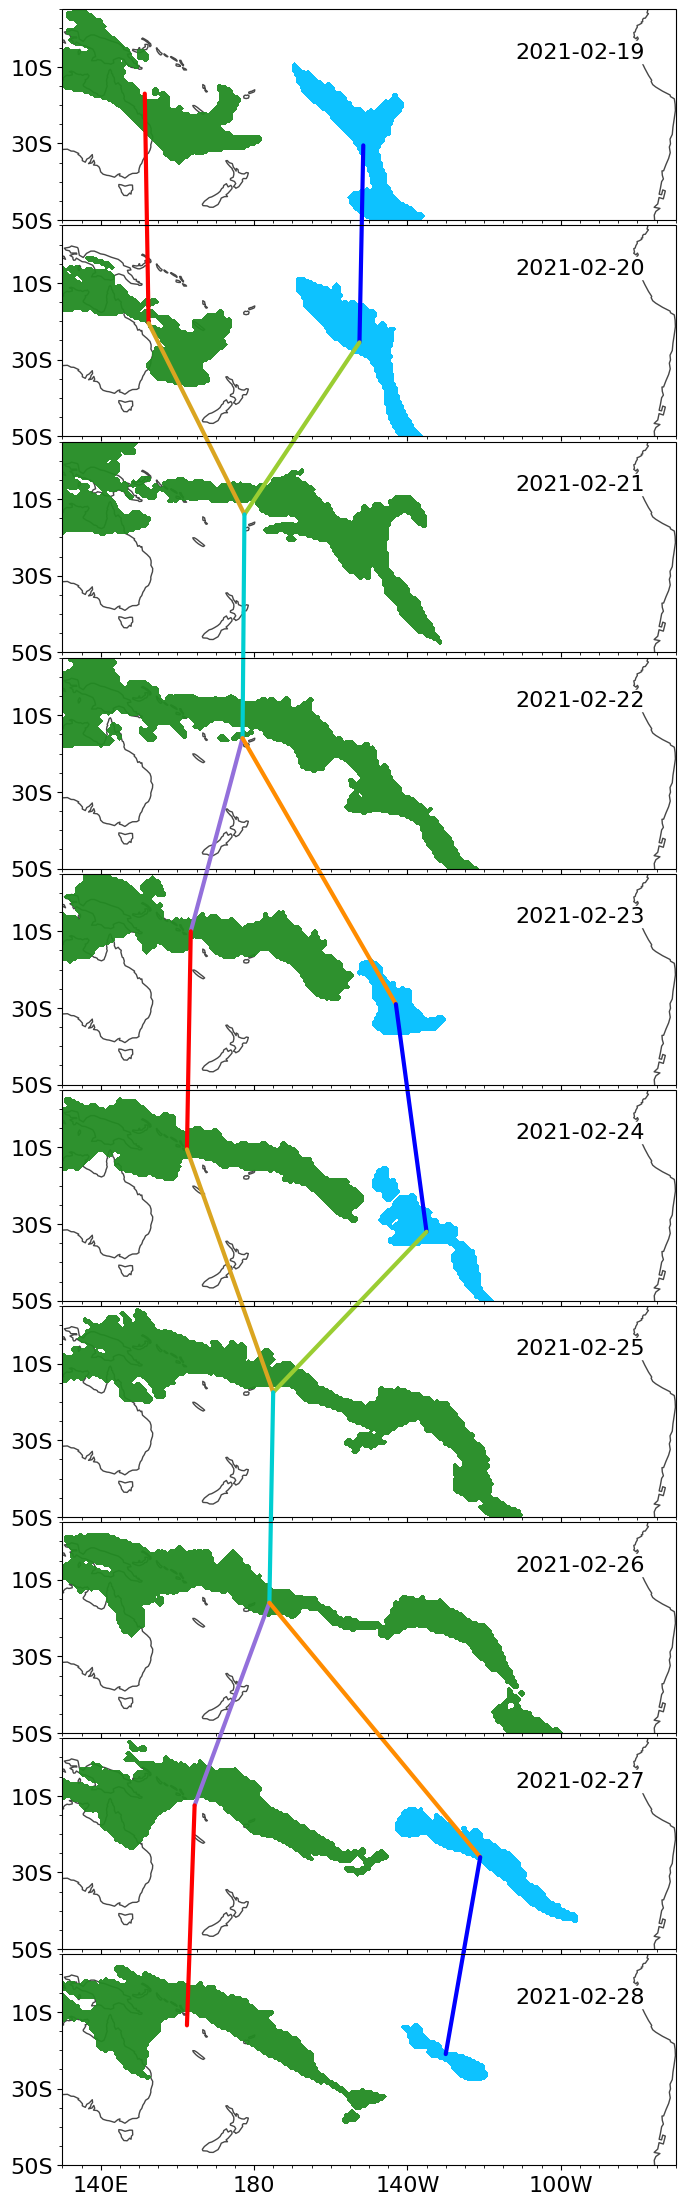

In [9]:
plot_tracking_on_map(
    list_of_cloud_bands=list_of_cloud_bands,
    lons=lonsSP,
    lats=latsSP,
    listofdates=listofdates,
    config=config,
    show=True,
    save=False,
)